### Práctica 1 - Predicción Energía Eólica
Autores:
- Miguel Domínguez Gómez - 100451258
- ?  

Enlace al repositorio:
https://github.com/MiguelMHR/Practica1-PrediccionEnergia


### 0. Tabla de contenidos:
1. [Requisitos](#1.-Requisitos)
2. [Lectura](#2.-Lectura)
1. [EDA](#3.-EDA)

### 1. Requisitos

Importamos las librerías necesarias para el proyecto

In [1]:
# Importando las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\mikel\AppData\Local\Temp\ipykernel_5600\92614907.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 2. Lectura

Procedemos a leer el dataset usando la librería Pandas

In [2]:
# Leemos el dataset
wind_ava = pd.read_csv('./data/wind_ava.csv')
# Ver todas las columnas -> usamos head(1) y vemos los nombres de las columnas
pd.options.display.max_columns = None
print(wind_ava.head(1))

              datetime  energy     p54.162.1     p54.162.2     p54.162.3  \
0  2005-01-02 18:00:00  402.71  2.534970e+06  2.526864e+06  2.518754e+06   

      p54.162.4     p54.162.5     p54.162.6     p54.162.7     p54.162.8  \
0  2.510648e+06  2.502537e+06  2.531111e+06  2.522721e+06  2.514330e+06   

      p54.162.9    p54.162.10    p54.162.11    p54.162.12    p54.162.13  \
0  2.505940e+06  2.497549e+06  2.528052e+06  2.519436e+06  2.510824e+06   

     p54.162.14    p54.162.15    p54.162.16    p54.162.17    p54.162.18  \
0  2.502212e+06  2.493596e+06  2.525567e+06  2.516770e+06  2.507977e+06   

     p54.162.19    p54.162.20    p54.162.21    p54.162.22    p54.162.23  \
0  2.499180e+06  2.490388e+06  2.522309e+06  2.513282e+06  2.504254e+06   

     p54.162.24    p54.162.25  p55.162.1  p55.162.2  p55.162.3  p55.162.4  \
0  2.495227e+06  2.486199e+06   9.441719   9.403778   9.366515   9.328574   

   p55.162.5  p55.162.6  p55.162.7  p55.162.8  p55.162.9  p55.162.10  \
0   9.290633   9

### 3. EDA

En esta sección se hará un análisis exploratorio de datos siguiento las cuestiones expuestas en el enunciado de la práctica

#### 3.0 Preparación previa del dataset
Como se expone en el punto **importante** de la práctica, debemos, antes de realizar el EDA simplificado, una limpieza de las columnas que no sean importantes. Las únicas que son relevantes son aquellas que tienen que ver con Sotavento:
- **datetime**
- **energy**
- solo aquellas que tengan un ".13" al final (**p54.162.13, p55.162.13, cape.13, etc**)

In [3]:
# Para quedarme solo con las columnas que terminan por ".13" o que sean "energy" o "datetime"
columnas_a_mantener = [columna for columna in wind_ava.columns if columna.endswith('.13') or columna == 'energy' or columna == 'datetime']
wind_ava = wind_ava[columnas_a_mantener]
print(wind_ava.head(1))


              datetime  energy    p54.162.13  p55.162.13    cape.13  \
0  2005-01-02 18:00:00  402.71  2.510824e+06    9.186295  13.527577   

     p59.162.13  lai_lv.13  lai_hv.13   u10n.13   v10n.13         sp.13  \
0  1.386937e+06   2.344111   2.432983 -0.757587 -1.922799  99846.319914   

      stl1.13    u10.13    v10.13      t2m.13     stl2.13     stl3.13  \
0  280.960661 -0.906454 -2.709511  280.473098  281.042026  281.462478   

    iews.13  inss.13     stl4.13    fsr.13   flsr.13   u100.13   v100.13  
0 -0.057958 -0.13865  284.684755  0.404731 -5.927092 -1.780562 -4.443617  


#### 3.1 Descripción general del dataset
Para poder conocer ciertas características relevantes del dataset, como el número de instancias (filas) y característas (columnas) procederemos a usar diferentes funciones de Pandas con el dataset transformado

In [4]:
# Descripción de parámetros generales -> count, mean, std, min, 25%, 50%, 75%, max
print(wind_ava.describe())

# Número de filas y columnas del dataset
print("\n")
print("Número de filas: ", wind_ava.shape[0])
print("Número de columnas: ", wind_ava.shape[1])
print("\n")

# Para saber el tipo de variable de cada columna
print(wind_ava.info())

            energy    p54.162.13   p55.162.13      cape.13    p59.162.13  \
count  4748.000000  4.748000e+03  4748.000000  4748.000000  4.748000e+03   
mean    693.126247  2.489477e+06    16.008810    31.166541  1.706692e+06   
std     665.531609  4.482599e+04     6.552216   121.758977  1.466953e+06   
min       0.010000  2.358748e+06     1.650268     0.000000  5.610341e+04   
25%     144.170000  2.458543e+06    11.203264     0.000000  6.563209e+05   
50%     465.305000  2.490478e+06    15.543441     1.004148  1.239176e+06   
75%    1089.375000  2.525134e+06    20.214077    14.143328  2.296548e+06   
max    2792.550000  2.580387e+06    39.230807  2311.662152  1.110694e+07   

         lai_lv.13    lai_hv.13      u10n.13      v10n.13         sp.13  \
count  4748.000000  4748.000000  4748.000000  4748.000000   4748.000000   
mean      2.815222     2.576284     0.386215     0.120528  97820.301287   
std       0.397377     0.116434     3.100583     3.016766    713.689654   
min       2.323

Como se puede apreciar, no existen valores nulos ya que el número de filas (4748) coincide con la cuenta de los valores no-nulos de cada columna

#### 3.2 Valores faltantes

Como ya se ha visto en el anterior apartado, no existen valores nulos como tal. Para asegurarnos, haremos lo siguiente

In [5]:
# Para poder saber el número de valores faltantes:
print(wind_ava.isnull().sum())


datetime      0
energy        0
p54.162.13    0
p55.162.13    0
cape.13       0
p59.162.13    0
lai_lv.13     0
lai_hv.13     0
u10n.13       0
v10n.13       0
sp.13         0
stl1.13       0
u10.13        0
v10.13        0
t2m.13        0
stl2.13       0
stl3.13       0
iews.13       0
inss.13       0
stl4.13       0
fsr.13        0
flsr.13       0
u100.13       0
v100.13       0
dtype: int64


Ahora, comprobaremos, como todos son números decimales, si por casualidad hay algún cero que no tengan sentido en el dataset

In [6]:
# Ahora, comprobaremos, como todos son números decimales, si por casualidad hay algún cero que no tengan sentido en el dataset
# Para ello, veremos el número de ceros que hay en cada columna
print((wind_ava == 0).sum())



datetime         0
energy           0
p54.162.13       0
p55.162.13       0
cape.13       1492
p59.162.13       0
lai_lv.13        0
lai_hv.13        0
u10n.13          0
v10n.13          0
sp.13            0
stl1.13          0
u10.13           0
v10.13           0
t2m.13           0
stl2.13          0
stl3.13          0
iews.13          0
inss.13          0
stl4.13          0
fsr.13           0
flsr.13          0
u100.13          0
v100.13          0
dtype: int64


Se puede apreciar que en cape.13 hay bastantes valores que son cero pero, como esa variable tiene sentido que sea cero en determinados contextos, como en condiciones atmosféricas estables, se ha decidido mantener así

#### 3.3 Columnas constantes
En este apartado se evaluará qué columnas son constantes para todos sus valores

In [7]:
# Encontrar las columnas que tienen un solo valor único (columnas constantes)
constant_columns = wind_ava.columns[wind_ava.nunique() <= 1].tolist()
print(constant_columns)


[]


Como se puede apreciar, no existen columnas constantes, por lo que no se va a eliminar nada del dataset

#### 3.5 ¿Regresión o clasificación?
Directamente conociendo la naturaleza de la variable objetivo, la energía, se puede saber ante qué tipo de problema nos enfrentamos. Como la energía es una variable continua, nos encontramos ante un problema de regresión. 


#### 3.6 Otras consideraciones: outliers
Otro apartado del EDA que no se menciona en el enunciado y que creemos que es de vital importancia para realizar un buen análisis exploratorio es evaluar los valores lejanos, o outliers

#### 3.6.1 Outliers con Histograma

Usaremos varios métodos de representación de los datos para poder observar los valores alejados

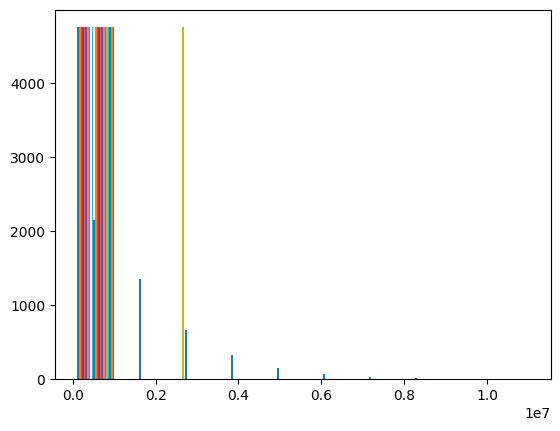

In [8]:

# Quitamos 'datetime' al no ser una columna numérica
columna_excluida = 'datetime'
plt.hist(wind_ava[wind_ava.columns.difference([columna_excluida])])
plt.show()

Se puede apreciar que hay ciertos valores que se salen de la norma, aunque se verá más claro realizando los boxplots

##### 3.6.2 Outliers con Boxplot
Para poder evaluar atributo a atributo, se procederá a hacer un boxplot de los 21 atributos (menos datetime, al no ser numérico y no tener outliers al ser un registro de las mediciones diarias)

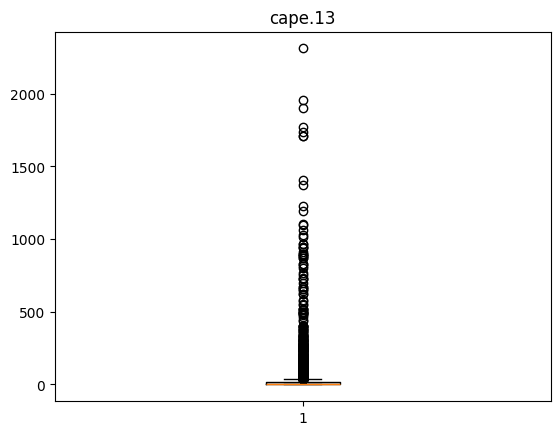

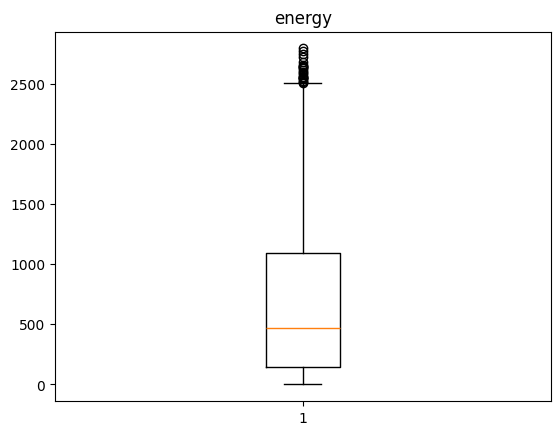

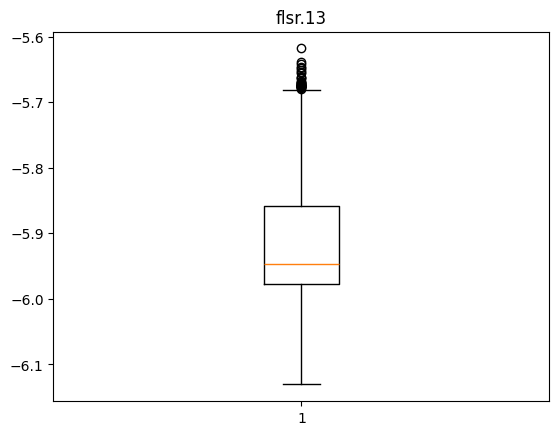

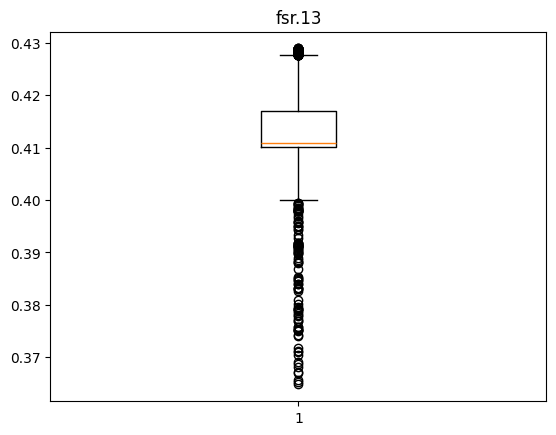

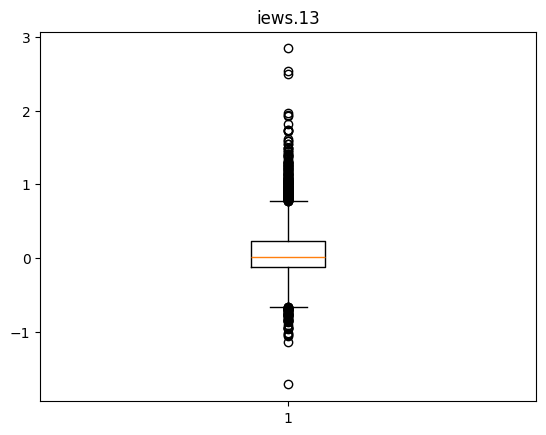

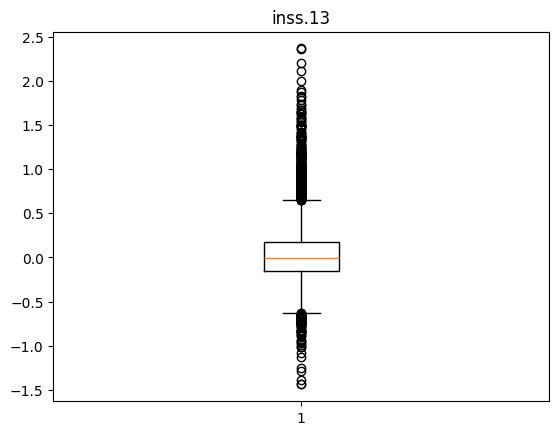

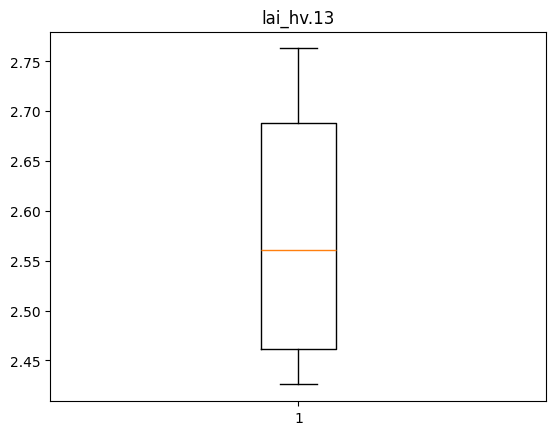

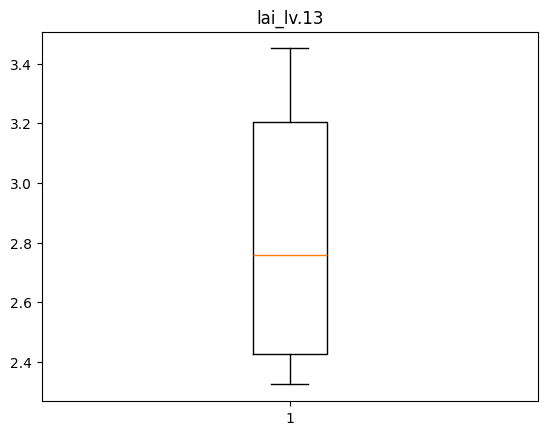

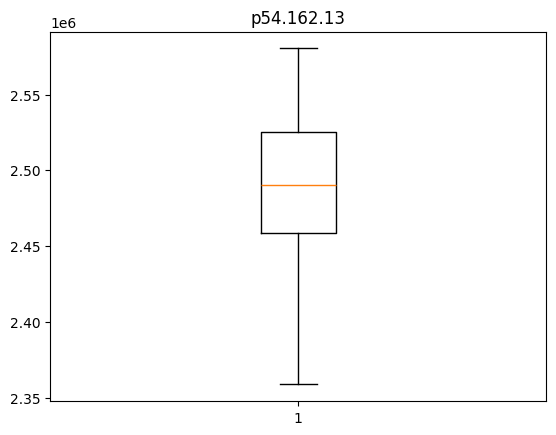

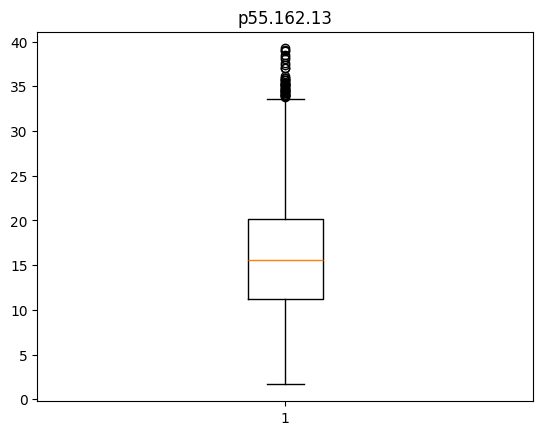

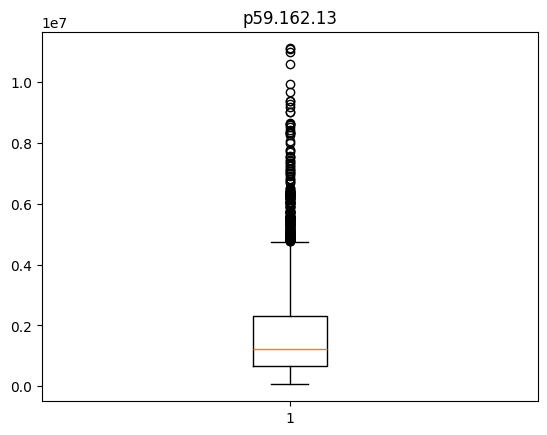

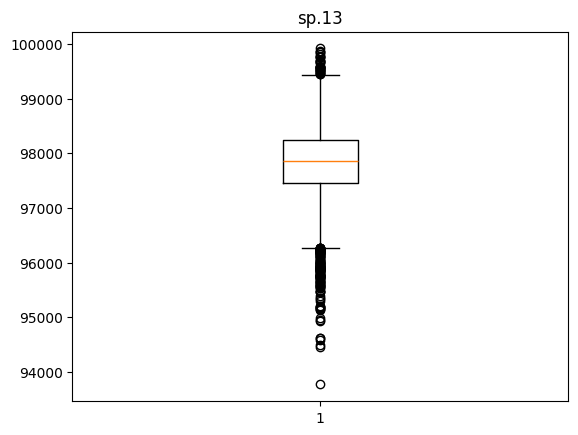

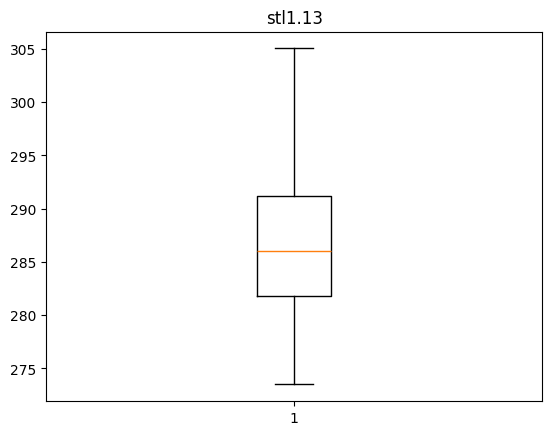

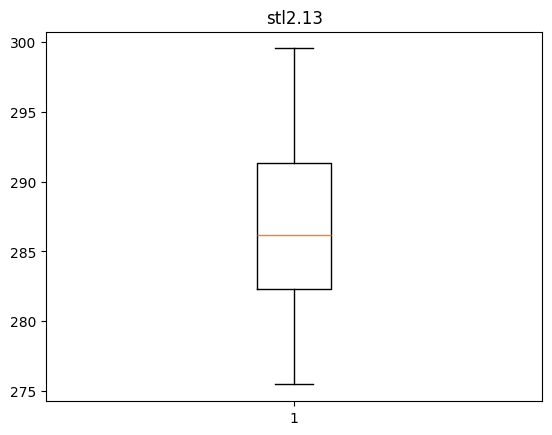

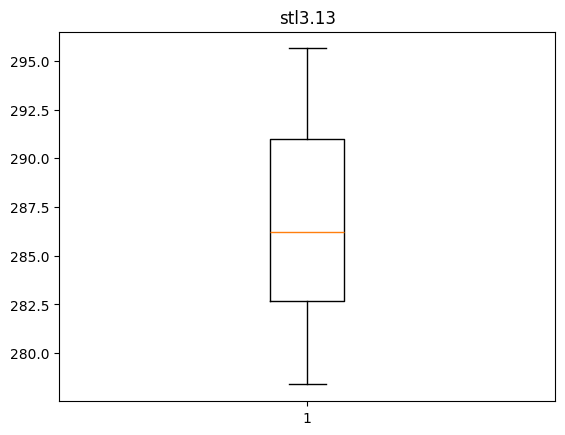

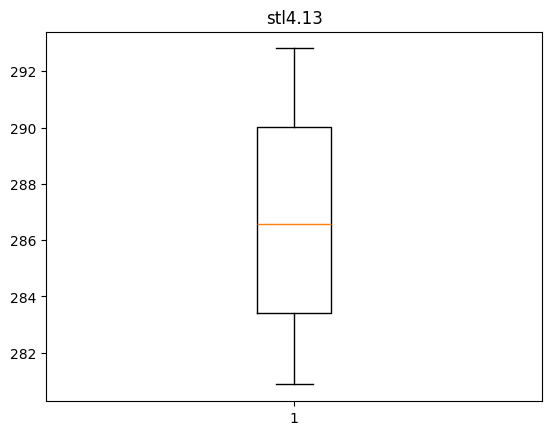

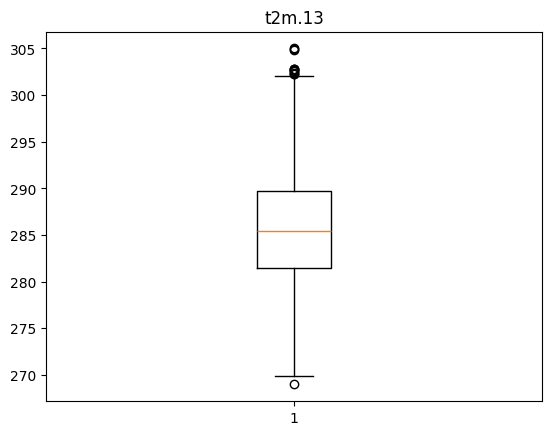

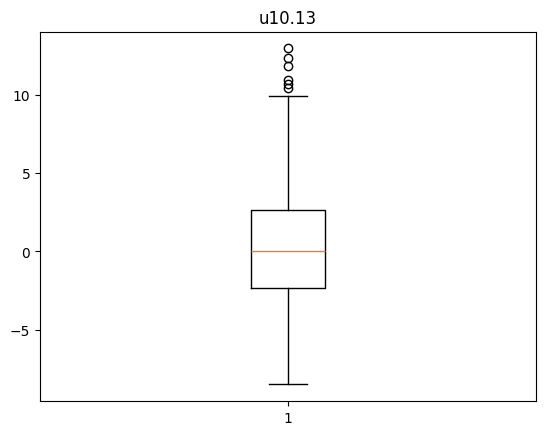

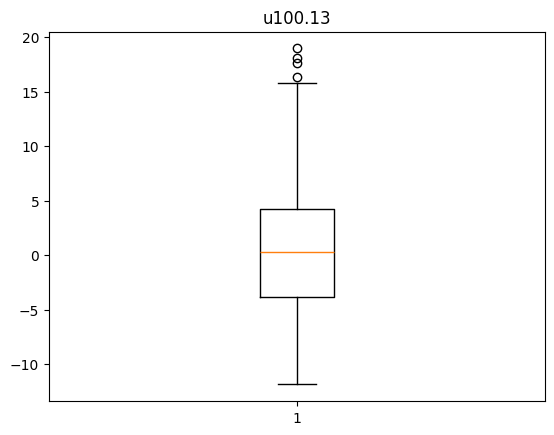

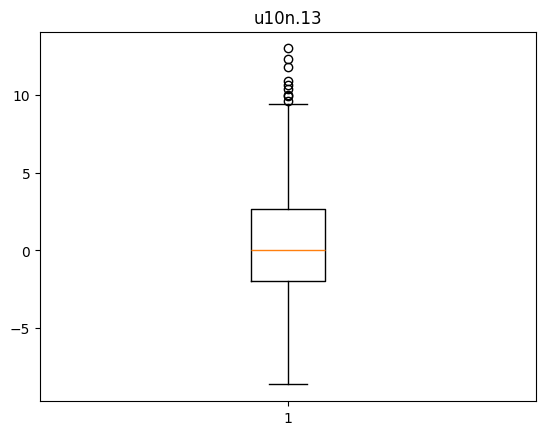

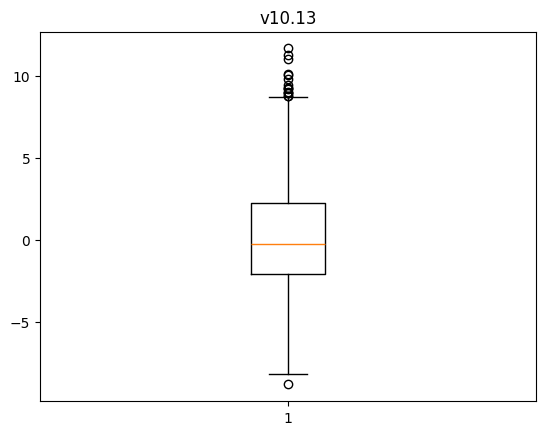

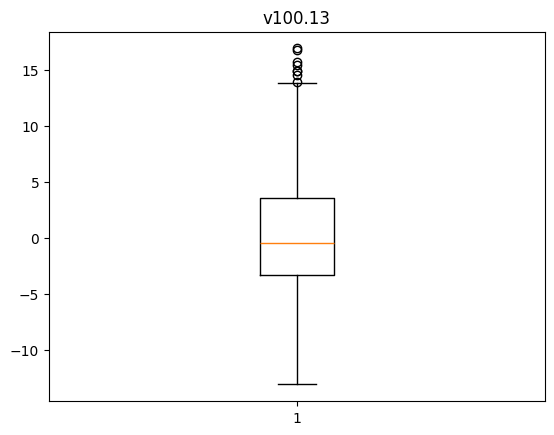

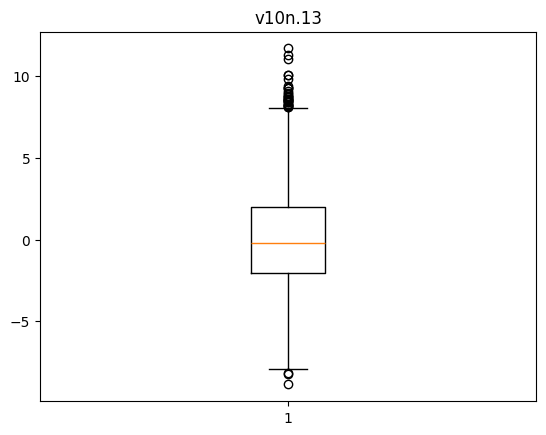

In [9]:
# Boxplot para cada atributo y sacamos los outliers de cada uno
outliers = []
for attribute in wind_ava.columns.difference([columna_excluida]):
    plt.boxplot(wind_ava[attribute])
    plt.title(attribute)
    plt.show()
    Q1 = wind_ava[attribute].quantile(0.25)
    Q3 = wind_ava[attribute].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers.append(wind_ava[(wind_ava[attribute] < lower_bound) | (wind_ava[attribute] > upper_bound)].index)

Como muestran los resultados, hay ciertos atributos que poseen bastantes outliers, otros que poseen algunos y hay otros atributos en los que es inexistente. Hace falta determinar si esos son ruido, para ser eliminados en futuros modelos para mejorar la predicción, o si son datos realmente significativos para el dataset. Al ser variables meteorológicas, cabe la posibilidad de que haya cierto fallo en la medición, pero al ser la metereología de una región algo tan cambiante, se cree que esa información debe prevalecer en el dataset, a pesar de poseer outliers

### 4. Evaluación outer y Evaluación inner

En este apartado se va a llevar a cabo la estimación del rendimiento a futuro (evaluación del modelo u outer) y la comparación de diferentes métodos y ajuste de hiperparámetros (evaluación inner)
Se usará como ejemplo KNN para realizar este primer acercamiento a la evaluación del dataset al igual que la división entre Train-Test de los datos